<a href="https://colab.research.google.com/github/ChaimaAraibi/Detecting-ASD-with-NLP-and-Deep-Learning/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- This notebook is for training an tensorflow model that classifies transcripts to predict if a child has ASD from their speech patterns.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [ ]:
# mounting drive to load the data
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# while loading the data from the drive, labels are added to the list 0 for typically developping children and 1 for children zith asd

import os
data = []

def load(path, label):
  for filename in os.listdir(path):
    data.append([open(path + filename).read(),label])
    

load("/content/drive/My Drive/stage2022textdata/td/", 0)
load("/content/drive/My Drive/stage2022textdata/nadig/", 1)
load("/content/drive/My Drive/stage2022textdata/eigsti/", 1)

len(data)

183

In [ ]:
import random
random.shuffle(data)

In [ ]:
## remove number & punctuation + lower data
import re

for d in data: 
  d[0] = re.sub(r'[^a-zA-Z :\\]', '', d[0])

data


- The first step is to tokenize words (giving a nuber to each unique word in corpus)

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
corpus = ""
for tr in data:
  corpus = corpus + tr [0]
corpus = corpus.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'<OOV>': 1, 'mot': 2, 'chi': 3, 'inv': 4, 'you': 5, 'the': 6, 'a': 7, 'it': 8, 'xxx': 9, 'i': 10, 'that': 11, 'vocalizes': 12, 'what': 13, 'oh': 14, 'is': 15, 'do': 16, 'this': 17, 'in': 18, 'yeah': 19, 'to': 20, 'and': 21, 'there': 22, 'can': 23, 'no': 24, 'on': 25, 'here': 26, 'baby': 27, 'go': 28, 'okay': 29, 'are': 30, 'its': 31, 'we': 32, 'gonna': 33, 'one': 34, 'put': 35, 'look': 36, 'thats': 37, 'whats': 38, 'wanna': 39, 'good': 40, 'your': 41, 'have': 42, 'dont': 43, 'see': 44, 'like': 45, 'up': 46, 'he': 47, 'me': 48, 'fat': 49, 'get': 50, 'with': 51, 'her': 52, 'know': 53, 'think': 54, 'for': 55, 'now': 56, 'some': 57, 'at': 58, 'want': 59, 'right': 60, 'nr': 61, 'out': 62, 'of': 63, 'say': 64, 'nv': 65, 'youre': 66, 'my': 67, 'going': 68, 'come': 69, 'all': 70, 'im': 71, 'laughs': 72, 'she': 73, 'they': 74, 'yes': 75, 'lets': 76, 'theres': 77, 'got': 78, 'down': 79, 'them': 80, 'not': 81, 'hes': 82, 'firstname': 83, 'more': 84, 'so': 85, 'x': 86, 'ball': 87, 'wheres': 88, '

- What comes next is creating and padding sequences 
- We need to encode the input data on a standard length 

In [ ]:
labels = [i[1] for i in data]
sequences = tokenizer.texts_to_sequences([i[0] for i in data])
padded = pad_sequences(sequences, padding='post')

In [ ]:
len(padded[0])

4627

In [ ]:
# splitting data to training and validation
x_train, x_test = np.asanyarray(padded[:130]), np.asanyarray(padded[131:])
y_train, y_test = np.asanyarray(labels[:130]), np.asanyarray(labels[131:])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 64),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          401024    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         41088     
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# call back function to stop training when high accuracy is reached
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.98):   
          print("0.98 of accuracy reached")   
          self.model.stop_training = True

In [ ]:
NUM_EPOCHS = 9
callbacks = myCallback()
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, validation_data=(x_test,y_test), batch_size=int(total_words/100), callbacks=[callbacks])

Epoch 1/9
3/3 [==============================] - 77s 22s/step - loss: 0.6926 - accuracy: 0.4538 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/9
3/3 [==============================] - 59s 19s/step - loss: 0.6868 - accuracy: 0.5385 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 3/9
3/3 [==============================] - 59s 19s/step - loss: 0.6800 - accuracy: 0.5385 - val_loss: 0.6792 - val_accuracy: 0.5000
Epoch 4/9
3/3 [==============================] - 60s 19s/step - loss: 0.6576 - accuracy: 0.5385 - val_loss: 0.6493 - val_accuracy: 0.5000
Epoch 5/9
3/3 [==============================] - 59s 19s/step - loss: 0.6114 - accuracy: 0.6231 - val_loss: 0.5629 - val_accuracy: 0.8077
Epoch 6/9
3/3 [==============================] - 58s 19s/step - loss: 0.4924 - accuracy: 0.7615 - val_loss: 0.3846 - val_accuracy: 0.8462
Epoch 7/9
3/3 [==============================] - 59s 19s/step - loss: 0.2999 - accuracy: 0.9231 - val_loss: 0.2195 - val_accuracy: 0.9231
Epoch 8/9
3/3 [===================

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

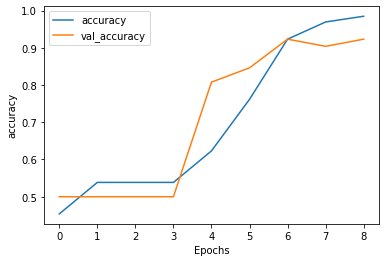

In [ ]:
plot_graphs(history, 'accuracy')

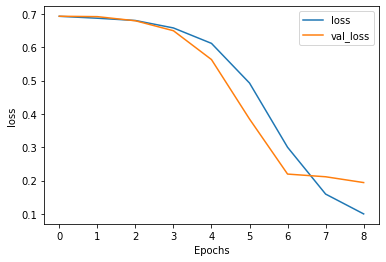

In [ ]:
plot_graphs(history, 'loss')